In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive


In [2]:
%cd gdrive/My\ Drive/GCN_AD/GCN-17-master/src

/content/gdrive/My Drive/GCN_AD/GCN-17-master/src


In [4]:
!pip install tensorflow==1.14.0
import tensorflow as tf
print(tf.__version__)
import sys, os
sys.path.insert(0, '..')
from lib import models, graph, coarsening, utils

import tensorflow as tf
import numpy as np
import time
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import LeaveOneOut
from scipy import stats
import numpy as np

#flags = tf.app.flags
#FLAGS = flags.FLAGS

# Graphs.
#flags.DEFINE_integer('number_edges', 10, 'Graph: minimum number of edges per vertex.')
#flags.DEFINE_string('metric', 'euclidean', 'Graph: similarity measure (between features).')
# TODO: change cgcnn for combinatorial Laplacians.
#flags.DEFINE_bool('normalized_laplacian', True, 'Graph Laplacian: normalized.')
#flags.DEFINE_integer('coarsening_levels', 2, 'Number of coarsened graphs.')
number_edges = 10
metric = 'euclidean'
normalized_laplacian = True
coarsening_levels = 2
# Directories.
#flags.DEFINE_string('dir_data', os.path.join('..', 'data', 'mnist'), 'Directory to store data.')
def grid_graph(m, corners=False):
    z = graph.grid(m)
    dist, idx = graph.distance_sklearn_metrics(z, k=number_edges, metric=metric)
    A = graph.adjacency(dist, idx)

    # Connections are only vertical or horizontal on the grid.
    # Corner vertices are connected to 2 neightbors only.
    if corners:
        import scipy.sparse
        A = A.toarray()
        A[A < A.max()/1.5] = 0
        A = scipy.sparse.csr_matrix(A)
        print('{} edges'.format(A.nnz))
    print("{} > {} edges".format(A.nnz//2, number_edges*m**2//2))
    return A

t_start = time.process_time()
A = grid_graph(75, corners=False)
A = graph.replace_random_edges(A, 0)
graphs, perm = coarsening.coarsen(A, levels=coarsening_levels, self_connections=False)
L = [graph.laplacian(A, normalized=True) for A in graphs]
print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
#graph.plot_spectrum(L)
#del A

features = np.loadtxt(open("../final_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94) )
features = features.transpose()
features = stats.zscore(features)
y = np.loadtxt(open("../all_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94))
y = y[0,:]

bin_ixs = []
train_ixs = []
 
skf = StratifiedKFold(n_splits=10)
for train_index, test_index in skf.split(features, y):
    bin_ixs.append(test_index)

common = {}
common['dir_name']       = 'mnist/'
common['num_epochs']     = 15
common['batch_size']     = 10
common['eval_frequency'] = common['num_epochs']
common['brelu']          = 'b1relu'
common['pool']           = 'mpool1'
C = max(y) + 1  # number of classes

model_perf = utils.model_perf()

1.14.0
29445 > 28125 edges
Layer 0: M_0 = |V| = 6092 nodes (467 added),|E| = 29445 edges
Layer 1: M_1 = |V| = 3046 nodes (107 added),|E| = 13097 edges
Layer 2: M_2 = |V| = 1523 nodes (0 added),|E| = 5754 edges
Execution time: 4.80s


In [5]:
total_accuracies = []
all_scores = []
all_labels = []
fontsize = False
sep = '*' * 100
for runs in range(10):
    print("\n RUN: {} {} \n".format(runs, sep))
    fold_acc = []
    roc_scores = []
    labels = []
    
    for i in range(skf.get_n_splits(features, y)):
        bins = list(range(skf.get_n_splits(features, y)))
        print("\n Fold: {} {} \n".format(i, sep))
        train_data = np.empty([0,features.shape[1]])
        train_labels = [] 
        val_ix = i
        if val_ix == max(bins):
            test_ix = 0
            bins.remove(val_ix)
            bins.remove(test_ix)

        else:
            test_ix = val_ix + 1
            bins.remove(test_ix)
            bins.remove(val_ix)

        val_data, val_labels = features[bin_ixs[val_ix]], y[bin_ixs[val_ix]]
        test_data, test_labels = features[bin_ixs[test_ix]], y[bin_ixs[test_ix]]
        for b in bins:
            train_data = np.concatenate((train_data, features[bin_ixs[b]]))
            train_labels = np.concatenate((train_labels, y[bin_ixs[b]]))

        #print(train_data.shape)
        #print(val_data.shape)
        #print(test_data.shape)

        #t_start = time.process_time()
        train_data = coarsening.perm_data(train_data, perm)
        val_data = coarsening.perm_data(val_data, perm)
        test_data = coarsening.perm_data(test_data, perm)

        common['decay_steps'] = len(train_labels) / common['batch_size']

        #print('Execution time: {:.2f}s'.format(time.process_time() - t_start))
        name = 'softmax'
        params = common.copy()
        params['dir_name'] += name
        params['regularization'] = 0.5
        params['dropout']        = 0
        params['learning_rate']  = 0.02
        params['decay_rate']     = .8 #.95
        params['momentum']       = 0.9
        params['F']              = [10]
        params['K']              = [20]
        params['p']              = [1]
        params['M']              = [C]
        
        
        scores, y_labels, test_accuracy = model_perf.show(model_perf.test(models.cgcnn(L, **params), name, params, train_data, train_labels, val_data, val_labels, test_data, test_labels, val_ix))
                                                         #model, name, params, train_data, train_labels, val_data, val_labels, test_data, test_labels, bin_ix)
        fold_acc = np.append(fold_acc, test_accuracy)
        roc_scores = np.append(roc_scores, scores)
        labels = np.append(labels, y_labels)  
    roc_scores = [roc_scores]
    labels = [labels]
    all_scores = np.append(all_scores, roc_scores)
    all_labels = np.append(all_labels, labels)
    fold_avg = np.mean(fold_acc)
    total_accuracies = np.append(total_accuracies, fold_avg)


 RUN: 0 **************************************************************************************************** 


 Fold: 0 **************************************************************************************************** 







Instructions for updating:
Use `tf.cast` instead.






Instructions for updating:
Use standard file APIs to delete files with this prefix.
validation accuracy: peak = 50.00, mean = 42.50
Instructions for updating:
Use standard file APIs to check for files with this prefix.
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/GCN_AD/GCN-17-master/lib/../checkpoints/mnist/softmax/model-109
train accuracy: 100.00 (73 / 73), f1 (weighted): 100.00, loss: 5.76e-01
time: 1s (wall 0s)
INFO:tensorflow:Restoring parameters from /content/gdrive/My Drive/GCN_AD/GCN-17-master/lib/../checkpoints/mnist/softmax/model-109
test  accuracy: 70.00 (7 / 10), f1 (weighted): 67.03, loss: 9.53e-01
time: 0s (wall 0s)

 Fold: 1 *******************************************

In [6]:
print("Runs Avg: {}".format(np.mean(total_accuracies)))
print("Standard Deviation: {}".format(np.std(total_accuracies)))

Runs Avg: 57.45555555555554
Standard Deviation: 5.4513448335091725


# Baseline

In [8]:
from sklearn.model_selection import StratifiedKFold
from scipy import stats
import numpy as np
from sklearn import linear_model, svm
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

features = np.loadtxt(open("../final_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94) )
features = features.transpose()
features = stats.zscore(features)
y = np.loadtxt(open("../all_data.csv", "rb"), delimiter=",", skiprows=1, usecols=range(1,94))
y = y[0,:]
lr_all_accs = []
lr_all_scores = []
svm_all_accs = []
svm_all_scores = []
base_labels = []
for runs in range(10):
    lr_accuracies = []
    lr_scores = []
    svm_accuracies = []
    svm_scores = []
    strat_labels = []

    rbf = svm.SVC(kernel='linear')
    logistic = linear_model.LogisticRegression(C=1e5)

    skf = StratifiedKFold(n_splits=10)
    for train_index, test_index in skf.split(features, y):
        train_data, test_data = features[train_index], features[test_index]
        train_labels, test_labels = y[train_index], y[test_index]
        
        strat_labels = np.append(strat_labels, test_labels)

        log = logistic.fit(train_data, train_labels)
        log_prob = log.decision_function(test_data)
        log_acc = log.score(test_data, test_labels)
        lr_accuracies = np.append(lr_accuracies, log_acc)
        lr_scores = np.append(lr_scores, log_prob)
        #print('Logistic Regression Accuracy: %f' % log_acc)

        rbf = rbf.fit(train_data, train_labels)
        svm_acc = rbf.score(test_data, test_labels)
        svm_prob = rbf.decision_function(test_data)
        #print('SVM Accuracy: %f' % svm_acc)
        svm_accuracies = np.append(svm_accuracies, svm_acc)
        svm_scores = np.append(svm_scores, svm_prob)
   
    base_labels = np.append(base_labels, strat_labels)
    lr_all_scores = np.append(lr_all_scores, lr_scores)
    lr_fold_avg = np.mean(lr_accuracies)
    lr_all_accs = np.append(lr_all_accs, lr_fold_avg)
    svm_all_scores = np.append(svm_all_scores, svm_scores)
    svm_fold_avg = np.mean(svm_accuracies)
    svm_all_accs = np.append(svm_all_accs, svm_fold_avg)

In [9]:
print("LR Avg: {}".format(np.mean(lr_all_accs)))
print("LR Standard Deviation: {}".format(np.std(lr_all_accs)))
print("SVM Avg: {}".format(np.mean(svm_all_accs)))
print("SVM Standard Deviation: {}".format(np.std(svm_all_accs)))

LR Avg: 0.7011111111111112
LR Standard Deviation: 1.1102230246251565e-16
SVM Avg: 0.6333333333333332
SVM Standard Deviation: 1.1102230246251565e-16


# ROC Curve

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


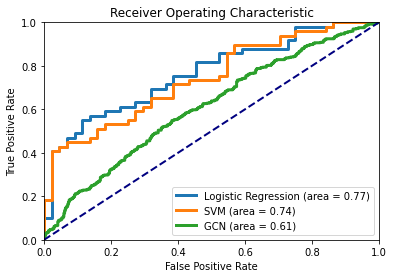

In [10]:
fpr = dict()
tpr = dict()
roc_auc = dict()

fpr['lr'], tpr['lr'], _ = roc_curve(base_labels, lr_all_scores)
roc_auc['lr'] = auc(fpr['lr'], tpr['lr'])
fpr['svm'], tpr['svm'], _ = roc_curve(base_labels, svm_all_scores)
roc_auc['svm'] = auc(fpr['svm'], tpr['svm'])
fpr['gcn'], tpr['gcn'], _ = roc_curve(all_labels, all_scores)
roc_auc['gcn'] = auc(fpr['gcn'], tpr['gcn'])

plt.figure()
plt.plot(fpr['lr'], tpr['lr'], lw=3, label='Logistic Regression (area = %0.2f)' % roc_auc['lr'])
plt.plot(fpr['svm'], tpr['svm'], lw=3, label='SVM (area = %0.2f)' % roc_auc['svm'])
plt.plot(fpr['gcn'], tpr['gcn'], lw=3, label='GCN (area = %0.2f)' % roc_auc['gcn'])
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
plt.savefig('10x_Combined_ROC.eps')
plt.show()